In [1]:
import numpy as np
from itertools import cycle
import os
import dask.array as da
import dask.bag as db
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import xesmf as xe
import subprocess
from scipy.ndimage import binary_fill_holes
from importlib import reload
# os.chdir("PATH TO WHERE YOU GIT CLONED") ## Make sure your kernel is in the same directory as the regional_library.py file
os.chdir("/g/data/x77/amh157/mom6-regional-scripts")
import regional_library as ml
from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 125.20 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43553,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 125.20 GiB
Comm: tcp://127.0.0.1:33105,Total threads: 4
Dashboard: /proxy/44175/status,Memory: 17.89 GiB
Nanny: tcp://127.0.0.1:39963,


# What does this package do?

Setting up a regional model in MOM6 is a pain. The goal of this package is that users should spend their debugging time fixing a model that's running and doing weird things, rather than puzzling over a model that won't even start.

In running this notebook, you'll hopefully have a running mom6 regional model. There will still be a lot of fiddling to do with the MOM_input file to make sure that the parameters are set up right for your domain, and you might want to manually edit some of the input files. BUT, this package should help you bypass most of the woes of regridding, encoding and understanding the arcane arts of the mom6 boundary segment files. 



This notebook is designed to showcase where we're up to so far. By the end you should have a running mom6 experiment on the domain of your choice. To make a stable test case:

* Avoid any regions with ice
* Avoid regions near the north pole
* Although the default configuration is meant to be RYF, I've not fixed up the calendar and encoding to run longer than a year just yet
* If you choose to do OM2-01 forcing, set your start date to 1990-01-01 which is what I've got it hardcoded to in step 2 option 2. 

Also hgrid is currently **not** mercator. It's equally spaced lat/long, with square cells at the centre of your domain and decrease in cell area away from equator. The pipeline is modular however, so if another hgrid generation function is written, it will be easy to pass say a gridtype="mercator" to the experiment class.

Input Type | Source
---|---
Surface | JRA (or ERA5 - see end of notebook)
Ocean | GLORYS reanalysis product OR ACCESS OM2-01
Bathymetry | Gebco

# Step 0: Your personal environment variables

In [2]:
scratch = "/scratch/x77/amh157"
home = "/home/157/amh157/"
## If using GLORYs, you'll need an email and password to access their database. make an account here: https://www.copernicus.eu/en/user/login?
pwd = "YOUR COPERNICUS PASSWORD"    
usr = "YOUR COPERNICUS USERNAME"  

# Step 1: Choose our domain, define workspace paths

To make sure that things are working I'd recommend starting with the default example defined below. If this runs ok, then change to a domain of your choice and hopefully it runs ok too! There's some troubleshooting you can do if not (check readme / readthedocs)

To find the lat/lon of the domain you want to test you can use <a href="https://data.marine.copernicus.eu/product/GLOBAL_MULTIYEAR_PHY_001_030/download" > this GUI </a> and copy paste below

In [3]:
expt_name = "indo-thru-flow"

## Choose your coordinates and the name of your experiment
yextent = [-12,2] ## latitude
xextent = [113,133] ## longitude

daterange = ["2171-01-01 00:00:00", "2171-01-05 00:00:00"] ## 2003 is a good compimise for GLORYs and JRA forcing as they overlap. JRA ends in 2012, GLORYS starts in 1993

## Place where all your input files go
inputdir = f"{scratch}/mom6_regional_configs/{expt_name}/"

## Directory where you'll run the experiment from
rundir = f"{home}/mom6_rundirs/{expt_name}/"

## Directory where fre tools are stored
toolpath = "/home/157/ahg157/repos/mom5/src/tools/" ## Compiled tools needed for construction of mask tables

## Directory where raw downloads go before processing
tmpdir = f"{scratch}/regional_tmp/{expt_name}"

for i in [rundir,tmpdir,inputdir]:
    if not os.path.exists(i):
        subprocess.run(f"mkdir {i} -p",shell=True)


# Step 2: Prepare ocean forcing data

We need to cut out our ocean forcing. The pipeline expects an initial condition and one time-dependent segment per non-land boundary. Naming convention is "east_unprocessed" and "ic_unprocessed" for initial condition. Execute either of the following cells to pick GLORYs reanalysis or ACCESS OM2-01

## For default 'Tassie' domain:
You can just read in the boundaries I've already downloaded. Overwrite your tmpdir and continue with the notebook without generating ocean forcing files

In [4]:
tmpdir = "/g/data/v45/ab8992/tassie-glorys"

## Option1: GLORYs
The following cell generates a bash script in your designated 'temporary directory'. This should be on scratch somewhere and just a container for your raw donloads.

To do this you'll need to register with the Copernicus data centre to get a username and password. Fill these in below.

After executing, navigate to this directory in your terminal and double check that all the files are there! Sometimes the data centre hangs and only retrieves a couple of files. In thise case, comment out the completed segments in `get_oceanfiles.sh` and run it again from terminal.

In [ ]:

file = open(f"{tmpdir}/get_oceanfiles.sh","w")
file.write(
        ml.motu_requests(xextent, yextent, daterange, tmpdir, usr, pwd,["north","south","east","west"])
)
file.close()

subprocess.run(
    f"bash {tmpdir}/get_oceanfiles.sh",shell=True
)


## Option 2: ACCESS OM2-01

If you have access to where it's located on Gadi, you can execute the following cell to cut out and save your segments and use these instead. The default I've set it at below is to cut out 3 months. To cut out a year, uncomment the code above which concatenates several input files together. Keep in mind that these input files are HUGE and they'll take a while to open and processes. To do a whole year, you'll want to run with a whole node and go make yourself a cup of coffee (and maybe read the paper for a bit). 

The advantage of doing this though is that the input files that the pipeline has to deal with are a lot smaller, making subsequent computation a lot quicker. An older iteration of the boundary brushcutter was to read data directly from the huge datasets, but this required some very careful chunking to not break your kernel. 

**NOTE: I haven't automated this properly and it's hardcoded for the year of 1990, which corresponds to files 1077 - 1082. Could maybe use COSIMA cookbook for this step instead?**

In [17]:

########## TWO OPTIONS: ############################

## Use this if you want to do a quick test for up to 3 months
om2_input = xr.open_mfdataset(f"/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output1080/ocean/ocean_daily*",parallel=True,chunks='auto').sel(time=slice(daterange[0],daterange[1]))

## Use this to cut out entire year 
# om2_input = xr.concat(
#     [xr.open_mfdataset(f"/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output{i}/ocean/ocean_daily*",decode_times = False,parallel=True,chunks='auto') for i in range(1077,1082)],
#     "time"
# )
#!  for i in range(1077,1082) is hardcoded to choose the year of 1990 Jan -> Dec 31. 
#######################################################

## Cut out initial condition and save
ic = om2_input[["u","v","salt","temp","eta_t"]].sel(    
    yu_ocean = slice(yextent[0] - 0.2,yextent[1] + 0.2),
    yt_ocean = slice(yextent[0] - 0.2,yextent[1] + 0.2)
).isel(time = 0)

## Nicer Slicer handles seams in longitude and different grids. Ensures that the output matches our 'xextend'
ic = ml.nicer_slicer(ic,[xextent[0],xextent[1]],["xu_ocean","xt_ocean"])
ic.to_netcdf(tmpdir + "/ic_unprocessed")

## Cut out East and West segments. Does lat slice first then uses nicer slicer for lon slice
eastwest = om2_input[["u","v","salt","temp","eta_t"]].sel(    
    yu_ocean = slice(yextent[0] - 0.2,yextent[1] + 0.2),
    yt_ocean = slice(yextent[0] - 0.2,yextent[1] + 0.2)
)
ml.nicer_slicer(eastwest,[xextent[1],xextent[1]],["xu_ocean","xt_ocean"]).to_netcdf(tmpdir + "/east_unprocessed")
ml.nicer_slicer(eastwest,[xextent[0],xextent[0]],["xu_ocean","xt_ocean"]).to_netcdf(tmpdir + "/west_unprocessed")

## Cut out North and South segments
northsouth = ml.nicer_slicer(om2_input[["u","v","salt","temp","eta_t"]],[xextent[0],xextent[1]],["xu_ocean","xt_ocean"])
northsouth.sel(
    yu_ocean = slice(yextent[1] - 0.2,yextent[1] + 0.2),
    yt_ocean = slice(yextent[1] - 0.2,yextent[1] + 0.2)
).to_netcdf(tmpdir + "/north_unprocessed")
northsouth.sel(
    yu_ocean = slice(yextent[0] - 0.2,yextent[0] + 0.2),
    yt_ocean = slice(yextent[0] - 0.2,yextent[0] + 0.2)
).to_netcdf(tmpdir + "/south_unprocessed")

# Step 3: Make experiment object
This object keeps track of your domain basics, as well as generating the hgrid, vgrid and setting up the folder structures. 

After running you can have a look at your grids by calling `expt.hgrid` and `expt.vgrid`

Plotting vgrid with marker = '.' option lets you see the spacing, or plotting 
```python
np.diff(expt.hgrid.zl).plot(marker = '.')
```
 shows you the vertical spacing profile.

## Modular workflow!

After constructing your expt object, if you don't like my lazy default hgrid and vgrid you can simply modify and overwrite them. However, you'll also need to save them to disk again as I've not automated this just yet. For example:

```python
expt.hgrid = custom_hgrid
expt.hgrid.to_netcdf(f"{inputdir}/hgrid.nc")
```

In [4]:
reload(ml)
expt = ml.experiment(
    xextent,
    yextent,
    daterange,
    0.05,  # Resolution
    75,    # Number of vertical layers
    10,    # Ratio of largest to smallest vertical layer. Select 1 for linear, negative number for higher resolution at bottom
    5000,  # Depth of simulation
    rundir,
    inputdir,
    toolpath
)

NOTE from make_solo_mosaic: there are 0 contacts (align-contact)
congradulation: You have successfully run make_solo_mosaic
FRE TOOLS: Make solo mosaic


CompletedProcess(args=['/home/157/ahg157/repos/mom5/src/tools/make_solo_mosaic/make_solo_mosaic', '--num_tiles', '1', '--dir', '.', '--mosaic_name', 'ocean_mosaic', '--tile_file', 'hgrid.nc'], returncode=0)


ln: failed to create symbolic link '/home/157/amh157//mom6_rundirs/indo-thru-flow//inputdir/indo-thru-flow': File exists
ln: failed to create symbolic link '/scratch/x77/amh157/mom6_regional_configs/indo-thru-flow//rundir/indo-thru-flow': File exists


# Step 4: Set up bathymetry

Similarly to ocean forcing, we point our 'bathymetry' method at the location of the file of choice, and pass it a dictionary mapping variable names. This time we don't need to preprocess the topography since it's just a 2D field and easier to deal with. Afterwards you can run `expt.topog` and have a look at your domain. After running this cell, your input directory will contain other topography - adjacent things like the ocean mosaic and mask table too. This defaults to a 10x10 layout which can be updated later.

In [5]:
expt.bathymetry(
    '/g/data/ik11/inputs/GEBCO_2022/GEBCO_2022.nc',
    {"xh":"lon",
     "yh":"lat",
     "elevation":"elevation"}, ## Again this dictionary just maps mom6 variable names to what they are in your topog.
     minimum_layers = 1
    )

 Starting weight generation with these inputs: 
   Source File: bathy_original.nc
   Destination File: topog_raw.nc
   Source variable names: elevation
   Destination variable names: elevation
   Souce Grid has a mask, using missingvalue    1.0000000000000000E+020
   Source File is in GRIDSPEC format with coordinate names lon lat
   Source Grid is a regional grid
   Destination File is in GRIDSPEC format with coordinate names lon lat
   Destination Grid is a regional grid
   Regrid Method: bilinear
   Pole option: NONE

 Completed file regrid successfully.

NOTE from make_solo_mosaic: there are 0 contacts (align-contact)
congradulation: You have successfully run make_solo_mosaic
MAKE SOLO MOSAIC

CompletedProcess(args='/home/157/ahg157/repos/mom5/src/tools/make_solo_mosaic/make_solo_mosaic --num_tiles 1 --dir . --mosaic_name ocean_mosaic --tile_file hgrid.nc', returncode=0)


cp: './ocean_mosaic.nc' and 'ocean_mosaic.nc' are the same file
cp: './hgrid.nc' and 'hgrid.nc' are the same file


cp ./hgrid.nc hgrid.nc 

NOTE from make_coupler_mosaic: the ocean land/sea mask will be determined by field depth from file topog.nc
mosaic_file is grid_spec.nc

***** Congratulation! You have successfully run make_quick_mosaic
QUICK MOSAIC

CompletedProcess(args='/home/157/ahg157/repos/mom5/src/tools/make_quick_mosaic/make_quick_mosaic --input_mosaic ocean_mosaic.nc --mosaic_name grid_spec --ocean_topog topog.nc', returncode=0)

 ===>NOTE from check_mask: when layout is specified, min_pe and max_pe is set to layout(1)*layout(2)=100

 ===>NOTE from check_mask: Below is the list of command line arguments.

grid_file = ocean_mosaic.nc
topog_file = topog.nc
min_pe = 100
max_pe = 100
layout = 10, 10
halo = 4
sea_level = 0
show_valid_only is not set
nobc = 0

 ===>NOTE from check_mask: End of command line arguments.

 ===>NOTE from check_mask: the grid file is version 2 (mosaic grid) grid which contains field gridfiles

==>NOTE from get_boundary_type: x_boundary_type is solid_walls

==>NOTE

### Check out your domain:

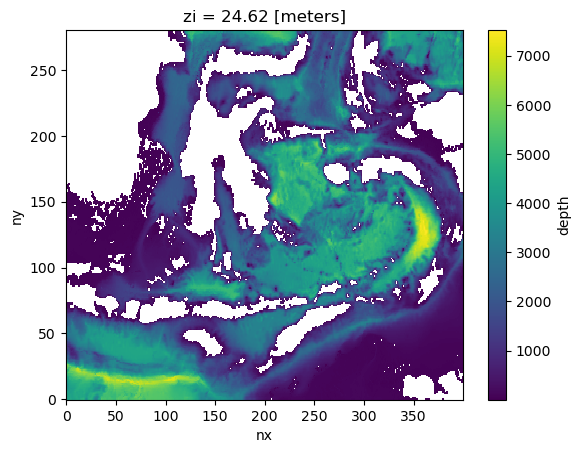

In [6]:
expt.topog.depth.plot()

#  Step 5: Handle the ocean forcing - where the magic happens

This cuts out and interpolates the initial condition as well as all boundaries (unless you don't pass it boundaries).

The dictionary maps the mom6 variable names to what they're called in your ocean input file. Notice how for GLORYs, the horizontal dimensions are x and y, vs xh, yh, xq, yq for ACCESS OM2-01. This is because for an 'A' grid type tracers share the grid with velocities so there's no difference.

If one of your segments is land, you can delete its string from the 'boundaries' list. You'll need to update MOM_input to reflect this though so it knows how many segments to look for, and their orientations. 

### **Note: Only run one of the two cells below according to what forcing you chose!**

In [8]:
## FOR GLORYS: 
expt.ocean_forcing(
    tmpdir,  ## Path to ocean foring files
    {"time":"time",
     "y":"latitude",
     "x":"longitude",
     "zl":"depth",
     "eta":"zos",
     "u":"uo",
     "v":"vo",
     "tracers":{"salt":"so",
                "temp":"thetao"
                }
    },
    boundaries = ["south","north","west","east"],
    gridtype="A"
)

INITIAL CONDITIONS
Regridding Velocities...Done.
Regridding Tracers...
Done.
Regridding Free surface...
Saving outputs... done.
BRUSHCUT BOUNDARIES
Processing south...Done.
Processing north...Done.
Processing west...Done.
Processing east...Done.


In [7]:
## FOR ACCESS OM2: 
expt.ocean_forcing(
    tmpdir,  ## Path to ocean foring files
    {"time":"time",
     "yh":"yt_ocean",
     "xh":"xt_ocean",
     "xq":"xu_ocean",
     "yq":"yu_ocean",
     "zl":"st_ocean",
     "eta":"eta_t",
     "u":"u",
     "v":"v",
     "tracers":{"salt":"salt","temp":"temp"}},
    boundaries = ["south","north","west","east"],
    gridtype="B"
    )

INITIAL CONDITIONS
Regridding Velocities...Done.
Regridding Tracers...
Done.
Regridding Free surface...
Saving outputs... done.
BRUSHCUT BOUNDARIES
Processing south...Done.
Processing north...Done.
Processing west...Done.
Processing east...Done.


# Step 6 (optional) Select number of processors 

This is just a wrapper for check_mask FRE tool. Choose the number of processors in the X and Y directions respectively. Having run `.bathymetry()`, you already have one set up for 10x10 by default.

In [9]:
expt.processor_mask((15,9))


 ===>NOTE from check_mask: when layout is specified, min_pe and max_pe is set to layout(1)*layout(2)=135

 ===>NOTE from check_mask: Below is the list of command line arguments.

grid_file = ocean_mosaic.nc
topog_file = topog.nc
min_pe = 135
max_pe = 135
layout = 15, 9
halo = 4
sea_level = 0
show_valid_only is not set
nobc = 0

 ===>NOTE from check_mask: End of command line arguments.

 ===>NOTE from check_mask: the grid file is version 2 (mosaic grid) grid which contains field gridfiles

==>NOTE from get_boundary_type: x_boundary_type is solid_walls

==>NOTE from get_boundary_type: y_boundary_type is solid_walls

==>NOTE from check_mask: Checking for possible masking:
==>NOTE from check_mask: Assume 4 halo rows
==>NOTE from check_mask: Total domain size is 400, 281

_______________________________________________________________________

NOTE from check_mask: The following is for using model source code with version older than siena_201207,
Possible setting to mask out all-land point

## Step 7 (optional) Regrid the runoff 

 This step will be removed in a future update when this functionality is added to rest of pipeline. Currently it calls a function from the legacy regional_model_scripts file. Just execute cell to give your domain runoff from JRA


In [10]:
from regional_model_scripts import regrid_runoff
runoff_path = "/g/data/ik11/inputs/JRA-55/RYF/v1-3/RYF.runoff_all.1990_1991.nc" ## Can change to match your year

regrid_runoff(inputdir + "ocean_mask.nc",
    inputdir + "hgrid.nc",
    runoff_path,
    inputdir + "runoff_regrid.nc",
    np.array(xextent) - np.array([180,180]),
    yextent)

# Step 8: Modify the default input directory to make a (hopefully) runnable configuration out of the box

This cell just copies a default run directory and modifies it to match your configuration.



In [18]:
subprocess.run(f"cp default_rundir/jra_surface/* {rundir} -r",shell = True)
# subprocess.run(f"cp default_rundir/era5_surface/* {rundir} -r",shell = True)
subprocess.run(f"ln -s {inputdir} {rundir}/inputdir",shell=True)

hgrid = xr.open_dataset(f"{inputdir}/hgrid.nc")

## Get mask table information
ncpus = 10
mask_table = None
for i in os.listdir(f"{inputdir}"):
    if "mask_table" in i:
        mask_table = i
        a = mask_table.split(".")[1]
        b = mask_table.split(".")[2].split("x")
        ncpus = int(b[0]) * int(b[1]) - int(a)


## Modify MOM_input
inputfile = open(f"{rundir}/MOM_input",'r')
lines = inputfile.readlines()
inputfile.close()
for i in range(len(lines)):
    if "MASKTABLE" in lines[i]:
        if mask_table != None:
            lines[i] = f'MASKTABLE = "{mask_table}"\n'
        else:
            lines[i] = "# MASKTABLE = no mask table"
    if "LAYOUT" in lines[i]:
        if "IO" not in lines[i]:
            lines[i] = f'LAYOUT = {expt.layout[1]},{expt.layout[0]}\n'

    if "NIGLOBAL" in lines[i]: 
        # lines[i] = f"NIGLOBAL = {str(x_indices_centre[1] - x_indices_centre[0])}\n"
        lines[i] = f"NIGLOBAL = {hgrid.nx.shape[0]//2}\n"

        
    if "NJGLOBAL" in lines[i]:
        # lines[i] = f"NJGLOBAL = {str(y_indices_centre[1] - y_indices_centre[0])}\n"
        lines[i] = f"NJGLOBAL = {hgrid.ny.shape[0]//2}\n"

        
inputfile = open(f"{rundir}/MOM_input",'w')

inputfile.writelines(lines)
inputfile.close()

## Modify SIS_input
inputfile = open(f"{rundir}/SIS_input",'r')
lines = inputfile.readlines()
inputfile.close()
for i in range(len(lines)):
    if "MASKTABLE" in lines[i]:
        lines[i] = f'MASKTABLE = "{mask_table}"\n'
    if "NIGLOBAL" in lines[i]:
        # lines[i] = f"NIGLOBAL = {str(x_indices_centre[1] - x_indices_centre[0])}\n"
        lines[i] = f"NIGLOBAL = {hgrid.nx.shape[0]//2}\n"
    if "LAYOUT =" in lines[i]:
        if "IO" not in lines[i]:
            lines[i] = f'LAYOUT = {expt.layout[1]},{expt.layout[0]}\n'
    if "NJGLOBAL" in lines[i]:
        # lines[i] = f"NJGLOBAL = {str(y_indices_centre[1] - y_indices_centre[0])}\n"
        lines[i] = f"NJGLOBAL = {hgrid.ny.shape[0]//2}\n"
        
inputfile = open(f"{rundir}/SIS_input",'w')
inputfile.writelines(lines)
inputfile.close()

## Modify config.yaml 
inputfile = open(f"{rundir}/config.yaml",'r')
lines = inputfile.readlines()
inputfile.close()
for i in range(len(lines)):
    if "ncpus" in lines[i]:
        lines[i] = f'ncpus: {str(ncpus)}\n'
    if "jobname" in lines[i]:
        lines[i] = f"jobname: mom6_{expt_name}\n"
        
    if "input:" in lines[i]:
        lines[i + 1] = f"    - {inputdir}\n"

inputfile = open(f"{rundir}/config.yaml",'w')
inputfile.writelines(lines)
inputfile.close()


# Modify input.nml 
inputfile = open(f"{rundir}/input.nml",'r')
lines = inputfile.readlines()
inputfile.close()
for i in range(len(lines)):
    if "current_date" in lines[i]:
        tmp = daterange[0].split(" ")[0].split("-")
        lines[i] = f"{lines[i].split(' = ')[0]} = {int(tmp[0])},{int(tmp[1])},{int(tmp[2])},0,0,0,\n"

 
inputfile = open(f"{rundir}/input.nml",'w')
inputfile.writelines(lines)
inputfile.close()


ln: failed to create symbolic link '/home/157/amh157//mom6_rundirs/indo-thru-flow//inputdir/indo-thru-flow': File exists


# BONUS! Want to use ERA5 surface forcing instead?

This is WIP and not well tested but thought I'd include it

## SET UP ERA5 forcing:
Here we take the ERA forcing as it already exists on Gadi. For NCI users, you need access to the rt group. ERA5 - specific functions provided cut out the region of interest and fix up the metadata ready for MOM6.

For this example, we are forcing for the entire year of 2015 so we just generate a single forcing file with 2015's data.

Below is a table showing ERA5 characteristics and what needs to be done to sort it out
### Required ERA data:
Name | ERA filename | era variable name | notes
---|---|---|---
Surface Pressure | sp | sp | Pa :heavy_check_mark:
Surface Temperature | 2t | t2m | K :heavy_check_mark:
Meridional Wind | 10v | v10 | m/s :heavy_check_mark:
Zonal Wind | 10u | u10 | m/s :heavy_check_mark:
Specific Humidity | na | na | kg/kg, calculated from dewpoint temperature
Dewpoint Temperature | 2d | d2m | K


We can calculate specific humidity $q$ from dewpoint temperature $T_d$ and surface pressure $P$ via saturation vapour pressure $P_v$.

$\large P_v = 10^{8.07131 - \frac{1730.63}{233.426 + T}} \frac{101325}{760} $ Pascals

$\large q = 0.001 * 0.622  \frac{P_v}{P}$ 

In [ ]:
erapath = "/g/data/rt52/era5/single-levels/reanalysis"

## Firstly just open all raw data
rawdata = {}
for fname , vname in zip(["2t","10u","10v","sp","2d"] , ["t2m","u10","v10","sp","d2m"]):

    ## Cut out this variable to our domain size
    rawdata[fname] = ml.nicer_slicer(
        xr.open_mfdataset(f"{erapath}/{fname}/{daterange[0].split('-')[0]}/{fname}*",decode_times = False,chunks = {"longitude":100,"latitude":100}),
        xextent,
        "longitude"
    ).sel(
        latitude = slice(yextent[1],yextent[0]) ## This is because ERA5 has latitude in decreasing order (??)
    )

    ## Now fix up the latitude and time dimensions

    rawdata[fname] = rawdata[fname].isel(
        latitude = slice(None,None,-1) ## Flip latitude        
        ).assign_coords(
        time = np.arange(0,rawdata[fname].time.shape[0],dtype=float) ## Set the zero date of forcing to start of run
        )
    

    

    rawdata[fname].time.attrs = {"calendar":"julian","units":f"hours since {daterange[0]}"} ## Fix up calendar to match

    if fname == "2d":
        ## Calculate specific humidity from dewpoint temperature 
        q = xr.Dataset(
            data_vars= {
                "q": (0.622 / rawdata["sp"]["sp"]) * (10**(8.07131 - 1730.63 / (233.426 + rawdata["2d"]["d2m"] - 273.15) )) * 101325 / 760
                }

        )
        q.q.attrs = {"long_name":"Specific Humidity","units": "kg/kg"}
        q.to_netcdf(f"{inputdir}/forcing/q_ERA5",unlimited_dims = "time",encoding = {"q":{"dtype":"double"}})
    else:
        rawdata[fname].to_netcdf(f"{inputdir}/forcing/{fname}_ERA5",unlimited_dims = "time",encoding = {vname:{"dtype":"double"}})


## Update the data table to match:

subprocess.run(f"cp default_rundir/era5_surface/data_table {rundir}/data_table",shell = True)